<a href="https://colab.research.google.com/github/Mmabatho/AI-For-Software-Engineeering-Week-3/blob/main/Task3Week3AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✓ spaCy is already installed
✓ Using en_core_web_sm model
AMAZON PRODUCT REVIEWS - NLP ANALYSIS

1. LOADING SPACY MODEL
-------------------------
Loaded model: core_web_sm
Model pipeline components: tok2vec, tagger, parser, attribute_ruler, lemmatizer, ner

2. PREPARING SAMPLE DATA
-------------------------
Sample dataset created with 10 reviews

Sample reviews:
1. I absolutely love my new Sony WH-1000XM4 headphones! The noise cancellation is incredible and the so...
2. The Apple iPhone 13 Pro has an amazing camera, but the battery life is disappointing. Not worth the ...
3. This Samsung Galaxy S21 is a great phone. The screen is beautiful and the processor is super fast. S...

3. IMPLEMENTING CUSTOM ENTITY RECOGNITION
----------------------------------------

4. IMPLEMENTING RULE-BASED SENTIMENT ANALYSIS
---------------------------------------------

5. PROCESSING REVIEWS
--------------------

Processing review 1...
  Products: WH-1000XM4
  Brands: Sony
  Sentiment: Positive (Score: 0

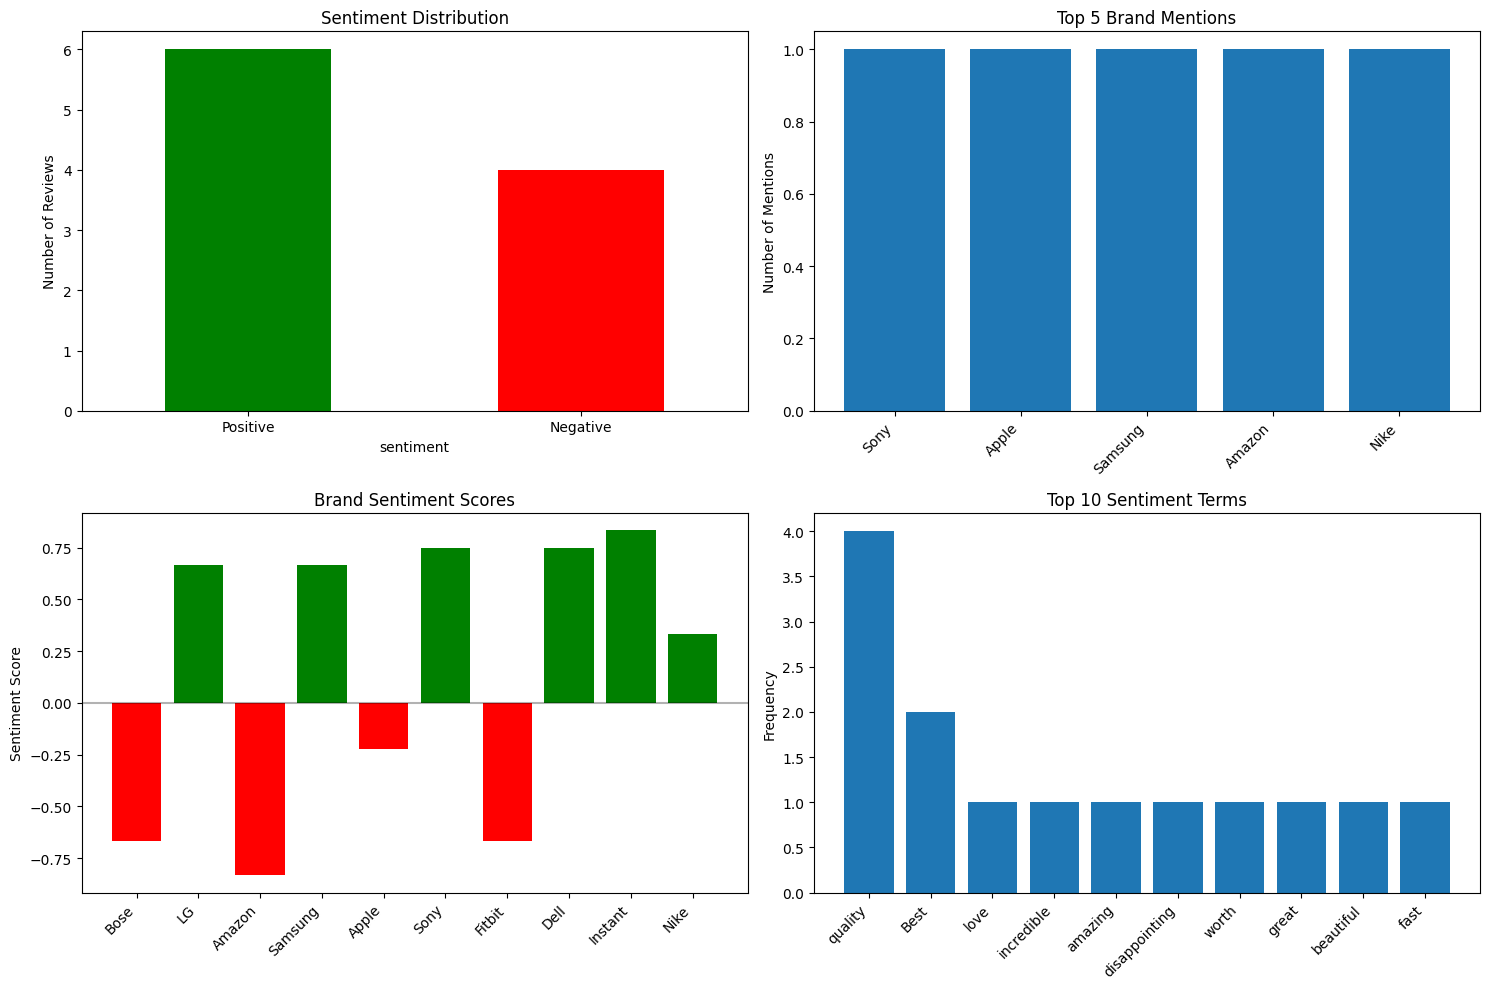

In [7]:
"""
NLP Analysis with spaCy: Amazon Product Reviews
==============================================

This script demonstrates:
1. Named Entity Recognition (NER) to extract product names and brands
2. Rule-based sentiment analysis
3. Visualization of results
"""

import os
import sys
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter

# First, check if spaCy is installed and install it if needed
try:
    import spacy
    print("✓ spaCy is already installed")
except ImportError:
    print("Installing spaCy...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "spacy"])
    import spacy
    print("✓ spaCy installed successfully")

# Check and install required spaCy model
try:
    # Try to load the medium model first
    nlp = spacy.load("en_core_web_md")
    print("✓ Using en_core_web_md model")
except OSError:
    try:
        # Try to load the small model as fallback
        nlp = spacy.load("en_core_web_sm")
        print("✓ Using en_core_web_sm model")
    except OSError:
        print("No spaCy models found. Installing en_core_web_sm...")
        subprocess.check_call([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
        nlp = spacy.load("en_core_web_sm")
        print("✓ Installed and loaded en_core_web_sm model")

# Now continue with the main script
from spacy.matcher import Matcher
from spacy.tokens import Span

print("=" * 60)
print("AMAZON PRODUCT REVIEWS - NLP ANALYSIS")
print("=" * 60)

# Step 1: Load spaCy model
print("\n1. LOADING SPACY MODEL")
print("-" * 25)
print(f"Loaded model: {nlp.meta['name']}")
print(f"Model pipeline components: {', '.join(nlp.pipe_names)}")

# Step 2: Sample Amazon Product Reviews
print("\n2. PREPARING SAMPLE DATA")
print("-" * 25)

# Create sample Amazon product reviews
reviews = [
    "I absolutely love my new Sony WH-1000XM4 headphones! The noise cancellation is incredible and the sound quality is top-notch. Best purchase this year!",
    "The Apple iPhone 13 Pro has an amazing camera, but the battery life is disappointing. Not worth the high price tag.",
    "This Samsung Galaxy S21 is a great phone. The screen is beautiful and the processor is super fast. Samsung really outdid themselves this time.",
    "I bought the Amazon Kindle Paperwhite last week and I'm not impressed. The screen is too dim and it freezes occasionally.",
    "The Nike Air Max 270 shoes are so comfortable! I can wear them all day without any pain. Nike always delivers quality products.",
    "My new LG OLED TV has stunning picture quality. The blacks are truly black and the colors pop. LG has the best TVs on the market right now.",
    "I regret buying the Bose QuietComfort earbuds. They keep falling out of my ears and the touch controls are too sensitive. Bose usually makes better products.",
    "The Dell XPS 13 laptop is perfect for my needs. It's lightweight, powerful, and the battery lasts all day. Dell has really improved their build quality.",
    "I'm disappointed with my Fitbit Versa 3. The step counter is inaccurate and the sleep tracking doesn't work properly. Fitbit needs to fix these issues.",
    "The Instant Pot Duo is a game changer in my kitchen! It cooks meals so quickly and everything turns out delicious. Best kitchen appliance I've ever owned!"
]

# Create a DataFrame for better organization
df = pd.DataFrame({"review_text": reviews})
print(f"Sample dataset created with {len(df)} reviews")
print("\nSample reviews:")
for i, review in enumerate(reviews[:3]):
    print(f"{i+1}. {review[:100]}...")

# Step 3: Define Custom Product and Brand Entity Recognition
print("\n3. IMPLEMENTING CUSTOM ENTITY RECOGNITION")
print("-" * 40)

# Define patterns for product names and brands
product_patterns = [
    # Electronics pattern
    [{"LOWER": {"IN": ["iphone", "galaxy", "pixel", "kindle", "paperwhite", "macbook", "surface"]}},
     {"IS_DIGIT": True, "OP": "?"},
     {"LOWER": {"IN": ["pro", "max", "ultra", "plus", "air", "mini"]}, "OP": "?"}],

    # Audio products
    [{"LOWER": {"IN": ["airpods", "quietcomfort", "wh-1000xm4"]}},
     {"LOWER": {"IN": ["pro", "max", "ultra", "plus"]}, "OP": "?"}],

    # Generic product patterns
    [{"POS": "PROPN"}, {"POS": "PROPN", "OP": "?"}, {"LOWER": {"IN": ["tv", "laptop", "phone", "headphones", "earbuds", "watch"]}}],
]

brand_patterns = [
    [{"LOWER": {"IN": ["apple", "samsung", "sony", "bose", "amazon", "google", "microsoft", "dell", "hp", "lenovo",
                       "lg", "nike", "adidas", "fitbit", "garmin", "instant", "kitchenaid", "dyson"]}}]
]

# Create a matcher for products and brands
product_matcher = Matcher(nlp.vocab)
for i, pattern in enumerate(product_patterns):
    product_matcher.add(f"PRODUCT_{i}", [pattern])

brand_matcher = Matcher(nlp.vocab)
for i, pattern in enumerate(brand_patterns):
    brand_matcher.add(f"BRAND_{i}", [pattern])

# Function to extract products and brands using the matcher
def extract_products_and_brands(doc):
    products = []
    brands = []

    # Use the matchers
    product_matches = product_matcher(doc)
    brand_matches = brand_matcher(doc)

    # Extract products
    for match_id, start, end in product_matches:
        span = doc[start:end]
        if span.text not in products:
            products.append(span.text)

    # Extract brands
    for match_id, start, end in brand_matches:
        span = doc[start:end]
        if span.text not in brands:
            brands.append(span.text)

    # Also use spaCy's built-in NER for ORG entities (potential brands)
    for ent in doc.ents:
        if ent.label_ == "ORG" and ent.text not in brands:
            brands.append(ent.text)

    return products, brands

# Step 4: Implement Rule-Based Sentiment Analysis
print("\n4. IMPLEMENTING RULE-BASED SENTIMENT ANALYSIS")
print("-" * 45)

# Define positive and negative word lexicons
positive_words = {
    "love", "great", "amazing", "excellent", "good", "best", "perfect", "awesome",
    "fantastic", "wonderful", "outstanding", "superb", "brilliant", "incredible",
    "comfortable", "quality", "stunning", "beautiful", "impressive", "delicious",
    "fast", "quick", "easy", "worth", "recommend", "happy", "pleased", "satisfied",
    "powerful", "lightweight", "durable", "reliable", "convenient", "innovative"
}

negative_words = {
    "hate", "bad", "terrible", "awful", "poor", "worst", "disappointing", "disappointed",
    "regret", "not worth", "overpriced", "expensive", "cheap", "break", "broke", "broken",
    "slow", "difficult", "hard", "heavy", "bulky", "uncomfortable", "pain", "issue", "problem",
    "defective", "malfunction", "error", "fail", "failed", "failure", "weak", "unreliable",
    "frustrating", "annoying", "irritating", "useless", "waste", "dim", "freezes", "inaccurate"
}

# Negation words that flip sentiment
negation_words = {"not", "no", "never", "neither", "nor", "barely", "hardly", "doesn't",
                 "don't", "didn't", "won't", "wouldn't", "couldn't", "shouldn't", "isn't",
                 "aren't", "wasn't", "weren't"}

# Intensifiers that strengthen sentiment
intensifiers = {"very", "really", "extremely", "absolutely", "completely", "totally",
               "utterly", "highly", "incredibly", "remarkably", "exceptionally", "truly",
               "especially", "particularly", "notably", "decidedly", "greatly", "substantially",
               "significantly", "markedly", "exceedingly", "immensely", "thoroughly", "quite",
               "so", "too", "such"}

def analyze_sentiment(doc):
    """
    Perform rule-based sentiment analysis on a spaCy doc.
    Returns a sentiment score and classification.
    """
    sentiment_score = 0
    sentiment_terms = []

    # Process each sentence separately
    for sent in doc.sents:
        # Track negation in the sentence
        negated = False
        intensified = False

        # Check each token in the sentence
        for i, token in enumerate(sent):
            # Check for negation words
            if token.lower_ in negation_words:
                negated = True
                continue

            # Check for intensifiers
            if token.lower_ in intensifiers:
                intensified = True
                continue

            # Check for positive words
            if token.lower_ in positive_words:
                modifier = -1 if negated else 1
                modifier *= 1.5 if intensified else 1
                sentiment_score += modifier
                sentiment_terms.append((token.text, modifier))
                negated = False
                intensified = False

            # Check for negative words
            elif token.lower_ in negative_words:
                modifier = 1 if negated else -1
                modifier *= 1.5 if intensified else 1
                sentiment_score += modifier
                sentiment_terms.append((token.text, modifier))
                negated = False
                intensified = False

    # Normalize the score between -1 and 1
    if sentiment_terms:
        sentiment_score = sentiment_score / (len(sentiment_terms) * 1.5)  # 1.5 is max intensity
        sentiment_score = max(min(sentiment_score, 1.0), -1.0)  # Clamp between -1 and 1

    # Classify the sentiment
    if sentiment_score > 0.1:
        sentiment = "Positive"
    elif sentiment_score < -0.1:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"

    return {
        "score": sentiment_score,
        "sentiment": sentiment,
        "terms": sentiment_terms
    }

# Step 5: Process the reviews
print("\n5. PROCESSING REVIEWS")
print("-" * 20)

# Process each review
results = []

for i, review in enumerate(reviews):
    print(f"\nProcessing review {i+1}...")

    # Process the text with spaCy
    doc = nlp(review)

    # Extract products and brands
    products, brands = extract_products_and_brands(doc)

    # Analyze sentiment
    sentiment_analysis = analyze_sentiment(doc)

    # Store the results
    result = {
        "review_id": i+1,
        "review_text": review,
        "products": products,
        "brands": brands,
        "sentiment_score": sentiment_analysis["score"],
        "sentiment": sentiment_analysis["sentiment"],
        "sentiment_terms": sentiment_analysis["terms"]
    }

    results.append(result)

    # Print a summary
    print(f"  Products: {', '.join(products) if products else 'None detected'}")
    print(f"  Brands: {', '.join(brands) if brands else 'None detected'}")
    print(f"  Sentiment: {sentiment_analysis['sentiment']} (Score: {sentiment_analysis['score']:.2f})")
    print(f"  Key terms: {', '.join([f'{term}({score:+.1f})' for term, score in sentiment_analysis['terms']])}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(f"\nProcessed {len(results_df)} reviews")

# Step 6: Analyze and Visualize Results
print("\n6. ANALYZING RESULTS")
print("-" * 20)

# Count sentiment distribution
sentiment_counts = results_df["sentiment"].value_counts()
print("\nSentiment Distribution:")
for sentiment, count in sentiment_counts.items():
    print(f"  {sentiment}: {count} reviews ({count/len(results_df)*100:.1f}%)")

# Extract all brands and products
all_brands = [brand for sublist in results_df["brands"].tolist() for brand in sublist]
all_products = [product for sublist in results_df["products"].tolist() for product in sublist]

# Count occurrences
brand_counts = Counter(all_brands)
product_counts = Counter(all_products)

print("\nTop Brands Mentioned:")
for brand, count in brand_counts.most_common(5):
    print(f"  {brand}: {count} mentions")

print("\nTop Products Mentioned:")
for product, count in product_counts.most_common(5):
    print(f"  {product}: {count} mentions")

# Calculate average sentiment by brand
brand_sentiment = {}
for brand in set(all_brands):
    brand_reviews = results_df[results_df["brands"].apply(lambda x: brand in x)]
    avg_sentiment = brand_reviews["sentiment_score"].mean()
    brand_sentiment[brand] = avg_sentiment

print("\nAverage Sentiment by Brand:")
for brand, score in sorted(brand_sentiment.items(), key=lambda x: x[1], reverse=True):
    sentiment = "Positive" if score > 0 else "Negative" if score < 0 else "Neutral"
    print(f"  {brand}: {score:.2f} ({sentiment})")

# Step 7: Visualize the Results
print("\n7. VISUALIZING RESULTS")
print("-" * 20)

try:
    # Set up the figure
    plt.figure(figsize=(15, 10))

    # Plot 1: Sentiment Distribution
    plt.subplot(2, 2, 1)
    colors = {'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'}
    sentiment_counts.plot(kind='bar', color=[colors.get(x, 'blue') for x in sentiment_counts.index])
    plt.title('Sentiment Distribution')
    plt.ylabel('Number of Reviews')
    plt.xticks(rotation=0)

    # Plot 2: Brand Mentions
    plt.subplot(2, 2, 2)
    brands_to_plot = [brand for brand, count in brand_counts.most_common(5)]
    brand_counts_to_plot = [brand_counts[brand] for brand in brands_to_plot]
    plt.bar(brands_to_plot, brand_counts_to_plot)
    plt.title('Top 5 Brand Mentions')
    plt.ylabel('Number of Mentions')
    plt.xticks(rotation=45, ha='right')

    # Plot 3: Brand Sentiment
    plt.subplot(2, 2, 3)
    brands = list(brand_sentiment.keys())
    sentiments = list(brand_sentiment.values())
    colors = ['green' if s > 0 else 'red' for s in sentiments]
    plt.bar(brands, sentiments, color=colors)
    plt.title('Brand Sentiment Scores')
    plt.ylabel('Sentiment Score')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.xticks(rotation=45, ha='right')

    # Plot 4: Sentiment Terms
    plt.subplot(2, 2, 4)
    all_terms = [term for result in results for term, score in result["sentiment_terms"]]
    term_counts = Counter(all_terms).most_common(10)
    terms = [term for term, count in term_counts]
    counts = [count for term, count in term_counts]
    plt.bar(terms, counts)
    plt.title('Top 10 Sentiment Terms')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig('amazon_reviews_analysis.png')
    print("Visualization saved as 'amazon_reviews_analysis.png'")
except Exception as e:
    print(f"Warning: Could not create visualizations. Error: {e}")
    print("Continuing with text analysis...")

# Step 8: Generate Detailed Report
print("\n8. GENERATING DETAILED REPORT")
print("-" * 30)

# Create a detailed report for each review
print("\nDETAILED ANALYSIS REPORT:")
print("=" * 80)

for result in results:
    print(f"\nREVIEW #{result['review_id']}")
    print("-" * 40)
    print(f"TEXT: {result['review_text']}")
    print(f"PRODUCTS: {', '.join(result['products']) if result['products'] else 'None detected'}")
    print(f"BRANDS: {', '.join(result['brands']) if result['brands'] else 'None detected'}")
    print(f"SENTIMENT: {result['sentiment']} (Score: {result['sentiment_score']:.2f})")

    # Print sentiment terms with their contribution
    print("SENTIMENT ANALYSIS:")
    for term, score in result["sentiment_terms"]:
        sentiment_type = "positive" if score > 0 else "negative"
        print(f"  - '{term}': {sentiment_type} term (contribution: {score:+.1f})")

    print("-" * 40)

# Step 9: Summary and Insights
print("\n9. SUMMARY AND INSIGHTS")
print("-" * 25)

# Calculate overall statistics
positive_reviews = len(results_df[results_df["sentiment"] == "Positive"])
negative_reviews = len(results_df[results_df["sentiment"] == "Negative"])
neutral_reviews = len(results_df[results_df["sentiment"] == "Neutral"])

avg_sentiment = results_df["sentiment_score"].mean()
most_positive_idx = results_df["sentiment_score"].idxmax()
most_negative_idx = results_df["sentiment_score"].idxmin()

print("\nOVERALL INSIGHTS:")
print(f"Total reviews analyzed: {len(results_df)}")
print(f"Sentiment breakdown: {positive_reviews} positive, {negative_reviews} negative, {neutral_reviews} neutral")
print(f"Average sentiment score: {avg_sentiment:.2f}")

if brand_counts:
    print(f"Most mentioned brand: {brand_counts.most_common(1)[0][0]} ({brand_counts.most_common(1)[0][1]} mentions)")

print("\nMost positive review:")
print(f"  \"{results_df.loc[most_positive_idx, 'review_text']}\"")
print(f"  Score: {results_df.loc[most_positive_idx, 'sentiment_score']:.2f}")

print("\nMost negative review:")
print(f"  \"{results_df.loc[most_negative_idx, 'review_text']}\"")
print(f"  Score: {results_df.loc[most_negative_idx, 'sentiment_score']:.2f}")

if brand_sentiment:
    print("\nBrand with most positive sentiment:")
    most_positive_brand = max(brand_sentiment.items(), key=lambda x: x[1])
    print(f"  {most_positive_brand[0]} (Score: {most_positive_brand[1]:.2f})")

    print("\nBrand with most negative sentiment:")
    most_negative_brand = min(brand_sentiment.items(), key=lambda x: x[1])
    print(f"  {most_negative_brand[0]} (Score: {most_negative_brand[1]:.2f})")

print("\n" + "=" * 60)
print("ANALYSIS COMPLETE!")
print("=" * 60)
